### 1. Carga del conjunto de datos

#### 1.1 Instalación de librerias necesarias y lectura de datos de kaggle

Como estamos trabajanod en sgaMaker y tenemos esta fase inical la ejecutamos una unica vez.

In [3]:
# Instalamos las librerias necesarias
!pip install opencv
!pip install google-colab
!pip install matplotlib
!pip install tensorflow
!pip install scipy
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade kaggle
!pip install sklearn

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 601.3 MB 13 kB/s s eta 0:00:0134 MB 4.6 MB/s eta 0:02:02MB/s eta 0:00:040:04
     |████████████████████████████████| 5.4 MB 29.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.1 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 28.2 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 796 kB/s  eta 0:00:01
     |████████████████████████████████| 294 kB 26.8 MB/s eta 0:

In [7]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Listar los datasets disponibles en kaggle para su descarga
!kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          12123        242  1.0              
arslaan5/explore-car-performance-fuel-efficiency-data        Explore Car Performance: Fuel Efficiency Data    5KB  2024-10-17 16:35:59           1160         26  1.0              
hasibur013/diabetes-dataset                                  Diabetes Dataset                                 9KB  2024-10-22 02:10:36            972         28  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset           

In [9]:
!kaggle datasets download chazzer/smiling-or-not-face-data

Dataset URL: https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data
License(s): CC0-1.0
 56%|█████████████████████                 | 10.0M/18.0M [00:00<00:00, 34.7MB/s]
100%|██████████████████████████████████████| 18.0M/18.0M [00:00<00:00, 54.3MB/s]


In [20]:
# Definimos ruta del dataset (donde se descargaron las imágenes)
dataset_path = 'my_dataset/'

Ruta pricipal: my_dataset/


In [11]:
# Creemos un directorio para descomprimir los datos con la opción p, si existe no se crea
!mkdir -p $dataset_path

In [12]:
# Descomprimir el archivo ZIP en la carpeta de destino
with zipfile.ZipFile('smiling-or-not-face-data.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

#### 1.2 Importación de todas las librerias necesarias

In [6]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import callbacks
from keras import regularizers
from keras.regularizers import l2, l1
from tensorflow.keras.optimizers import SGD, Adam, AdamW
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split

#### 1.3 Formación del conjunto de datos de entrenamiento

In [7]:
# Definimos una función que separa las imagenes por clases y le agrega una etiqueta de clase

def clasificacion_imagenes(dataset_path):
  classes = ['smile','non_smile'] # Lista de clases específicas (subdirectorios) a considerar
  all_images = []
  all_labels = []
  for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    print(f'Cantidad de imagenes de la clase {class_name} {len(class_images)}')
    all_images.extend(class_images)
    all_labels.extend([class_name] * len(class_images))
  return all_images, all_labels

# Definimos ruta del dataset (donde se descargaron las imágenes)
dataset_path = 'my_dataset/'
print(f'Ruta pricipal: {dataset_path}')

# Listar las subcarpetas en el directorio
subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Obtener la lista de todas las imágenes de entrenamiento y sus etiquetas
all_train_images = []
all_train_labels = []

# Rellenamos la lista con las imagenes y sus clases para el dataframe de entrenamiento y validación
all_train_images, all_train_labels = clasificacion_imagenes(dataset_path)

# Creamos un DataFrame con las rutas de las imágenes y sus etiquetas para el set de entrenamiento
df_train = pd.DataFrame({'filename': all_train_images, 'class': all_train_labels})

# Mezclamos aleatoriamente los datos
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(f'Cantidad total de imagenes {df_train.shape}')

Ruta pricipal: my_dataset/
Cantidad de imagenes de la clase smile 600
Cantidad de imagenes de la clase non_smile 603
Cantidad total de imagenes (1203, 2)


#### 1.4 Formación del conjunto de datos de test

In [3]:
# Dividimos del total de muestras 10% para test y 90% para training 
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=42)

# Mostramos la cantidad de muestras de test y entrenamiento
print(f'Cantidad total de imagenes para train {df_train.shape}')
print(f'Cantidad total de imagenes para test {df_test.shape}')

Cantidad de imagenes de la clase smile 38
Cantidad de imagenes de la clase non_smile 82


120

### 2. Inspección del conjunto de datos

my_dataset/smile/Michael_Winterbottom_0001.jpg
True


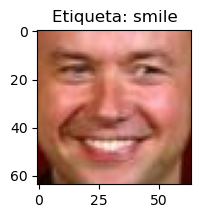

In [9]:
# Definimos una función para mostrar cualquier imagen dada como entrada

def mostrar_muestra(imagen,etiqueta):
    # Esta función recibe una imagen ya sea como "ruta de archivo" o como un "tensor"
    if isinstance(imagen,str): # Es ruta de archivo ?
        img = cv2.imread(imagen, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else: # Es tensor
        img = imagen
    plt.figure(figsize=(2, 2))
    plt.title(f"Etiqueta: {etiqueta}")
    plt.imshow(img)

idx = np.random.randint(1, 1200)
mostrar_muestra(df_train.iloc[idx,0],df_train.iloc[idx,1])
print(df_train.iloc[idx,0])
print(isinstance(df_train.iloc[idx,0],str))

### 3. Acondicionamiento del conjunto de datos

Debido a que nuestro conjunto de entrenamiento y validación es muy pequeño, sólo disponemos de 1200 muestras; por lo tanto en la formación de nuestros datos vamos con "ImageDataGenerator" de la librería Keras vamos a incluir "DataAugmentation".

In [10]:
def generacion_de_datos(es_conDataAugmentation,tamaño_imagen,batch_size):
    img_height = img_width = tamaño_imagen # Reescalado de la imagen
    classes = ['smile','non_smile']
    
    # Instanciamos una copia de ImageDataGenerador para el conjunto de datos de entrenamiento aplicando DataAugmentation
    if es_conDataAugmentation:
        train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,  # Rotación aleatoria
        width_shift_range=0.1, # fraccion del total (1) para mover la imagen
        height_shift_range=0.1, # fraccion del total (1) para mover la imagen
        horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
        #fill_mode ='nearest',
        validation_split=0.25
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)
    
    # Instanciamos una copia de ImageDataGenerador para el conjunto de datos de test
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Generadores de flujo de datos para conjuntos de entrenamiento, validación y prueba
    train_generator = train_datagen.flow_from_dataframe(
        df_train,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        subset='training',
        class_mode='binary')

    val_generator = train_datagen.flow_from_dataframe(
        df_train,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        subset='validation',
        class_mode='binary')

    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        class_mode='binary',
        batch_size=batch_size)
    
    return train_generator, val_generator, test_generator


---


# **ESTRATEGIA 1 - FROM SCRACH**


---

### 4. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [11]:
# Definición de los hiperparámetros y de generadores de datos
epochs = 20
img_width = img_height = 64
batch_size = 32
train_generator, val_generator, test_generator = generacion_de_datos(False,img_height,batch_size)

# Instanciamos nuestro modelo Secuencial
modelo_basico = Sequential(name="modelo_basico_cnn")

# Definimos el BASE MODEL
# Definimos 2 capas de 64 porque nos da mejores resultados para la extracción de caracteristicas del rostro

modelo_basico.add(layers.Conv2D(256, (3,3),input_shape=(img_width, img_height, 3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))
modelo_basico.add(layers.Conv2D(128, (3,3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))
modelo_basico.add(layers.Conv2D(64, (3,3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))

# Definimos el TOP MODEL

modelo_basico.add(layers.Flatten())
modelo_basico.add(layers.Dense(32,activation='relu'))
modelo_basico.add(layers.Dense(1,activation='sigmoid'))

modelo_basico.summary()

# Compilamos el modelo con los hiperparametros definidos
modelo_basico.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Entrenamos el modelo
his_basico = modelo_basico.fit(train_generator,
                     epochs = epochs,
                     validation_data = val_generator)


Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "modelo_basico_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,137 (1.93 MB)

 Trainable params: 507,137 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 752ms/step - accuracy: 0.5582 - loss: 0.6887 - val_accuracy: 0.6963 - val_loss: 0.6379
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 733ms/step - accuracy: 0.6980 - loss: 0.5904 - val_accuracy: 0.8407 - val_loss: 0.4027
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 726ms/step - accuracy: 0.8352 - loss: 0.3674 - val_accuracy: 0.8519 - val_loss: 0.4295
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 749ms/step - accuracy: 0.8844 - loss: 0.2733 - val_accuracy: 0.9111 - val_loss: 0.2364
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 722ms/step - accuracy: 0.8756 - loss: 0.3291 - val_accuracy: 0.9185 - val_loss: 0.2330
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 728ms/step - accuracy: 0.9184 - loss: 0.2234 - val_accuracy: 0.9111 - val_loss: 0.2086
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 704ms/step - accuracy: 0.9423 - loss: 0.1524 - val_accuracy: 0.9407 - val_loss: 0.1686
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 715ms/step - accuracy: 0.9597 - loss: 0.1336 - val_accu

### 5. Monitorización del proceso de entrenamiento para la toma de decisiones

In [12]:
# Preparamos un función que nos ayudara a graficar las curvas de aprendizaje

def grafica_curvas_aprendizaje(history, epocas):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epocas)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.ylim(0, 1) 
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.legend(loc='upper right')
    plt.show()

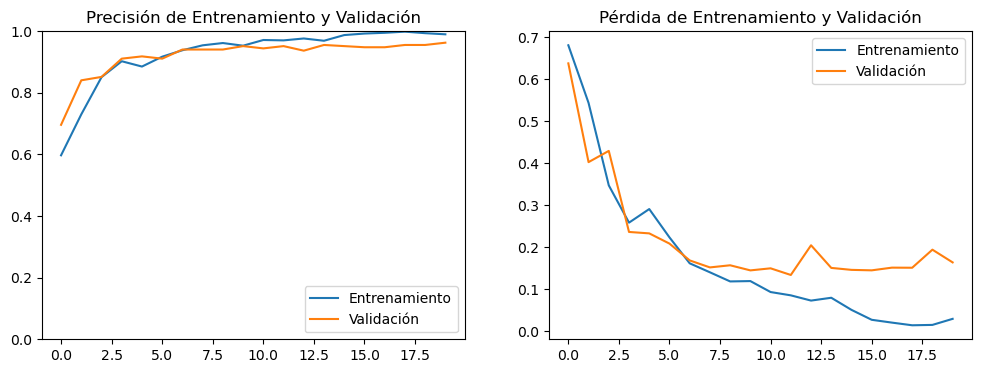

In [13]:
grafica_curvas_aprendizaje(his_basico, 20)

### 6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

In [14]:
def evaluacion_prediccion(modelo):
    # Evaluación del modelo en el conjunto de prueba
    test_loss, test_accuracy = modelo.evaluate(test_generator)
    print(f"Precisión en el conjunto de prueba: {test_accuracy}")

    sample_image, sample_label = next(test_generator)
    predict_label = (modelo.predict(sample_image) > 0.5).astype("int32")
    random_index = np.random.randint(0, len(sample_image))  # Índice aleatorio dentro del batch

    single_image = sample_image[random_index]
    single_label = sample_label[random_index]

    mostrar_muestra(single_image,"No smile" if single_label == 0 else "Smile")
    #predicted_labels = (modelo.predict(val_generator) > 0.5).astype("int32")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.9772 - loss: 0.1326
Precisión en el conjunto de prueba: 0.9586777091026306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


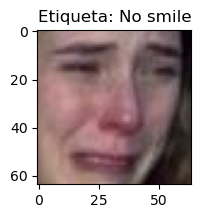

In [15]:
evaluacion_prediccion(modelo_basico)

**Análisis**

Apesar de tener valores muy buenos en la precisión tanto de entrenamiento como validación, sin embargo se observa que a partir de la 10va epoca el modelo presenta ligero sobreajuste pues la curva de pérdida deja de disminuir y separarse de la curva de entrenamiento. Esto puede indicar que el modelo esta aprendiendo características específicas del conjunto de datos de entrenamiento que no generalizan bien al conjunto de datos de validación. Un factor importante es que disponemos de pocas muestras en el dataset, por lo que se propone aplicar los siguientes métodos de regularización:

1. Aumento de Datos mediante la técnica de DataAugmentation.

2. Regularización Adicional: Agregando en cada capa oculta Dropout, Batchnormalization y regularización L2.

3. Programación de la Tasa de Aprendizaje: Mediante callback de reducción de tasa de aprendizaje cuando la métrica de validación deje de mejorar.

4. Incluir callbacks de EarlyStoping y Checkpoint. El primero para deterner el entrenaminto si el modelo empieza a sobreajustar y el segundo para quedarnos con los mejores pesos del modelo en su mejor momento.


#### Creación de nuevo modelo regularizado

In [16]:
# Definición de los hiperparámetros y de generadores de datos
epochs = 30
img_width = img_height = 64
batch_size = 32
# Usamos la función generación_de_datos con el Flag DataAugmentation en True
train_generator, val_generator, test_generator = generacion_de_datos(True,img_height,batch_size)

# Instanciamos nuestro modelo Secuencial
modelo_basico_reg = Sequential(name="modelo_basico_reg")

# Definimos el BASE MODEL
# Definimos 2 capas de 64 porque nos da mejores resultados para la extracción de caracteristicas del rostro

modelo_basico_reg.add(layers.Conv2D(128, (3,3),input_shape=(img_width, img_height, 3),padding="same",kernel_regularizer=l2(0.001),activation='relu'))
modelo_basico_reg.add(layers.MaxPooling2D(2,2))
modelo_basico_reg.add(layers.Dropout(0.1))
modelo_basico_reg.add(layers.Conv2D(64, (3,3),padding="same",kernel_regularizer=l2(0.001), activation='relu'))
modelo_basico_reg.add(layers.MaxPooling2D(2,2))
modelo_basico_reg.add(layers.Dropout(0.1))
modelo_basico_reg.add(layers.Conv2D(32, (3,3),padding="same",kernel_regularizer=l2(0.001), activation='relu'))
modelo_basico_reg.add(layers.MaxPooling2D(2,2))
modelo_basico_reg.add(layers.Dropout(0.1))

# Definimos el TOP MODEL

modelo_basico_reg.add(layers.Flatten())
modelo_basico_reg.add(layers.Dense(32,activation='relu'))
modelo_basico_reg.add(layers.Dropout(0.1))
modelo_basico_reg.add(layers.Dense(1,activation='sigmoid'))

modelo_basico_reg.summary()

# Compilamos el modelo con los hiperparametros definidos
optimizer = Adam(learning_rate=0.001)
modelo_basico_reg.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Entrenamos el modelo
his_basico_reg = modelo_basico_reg.fit(train_generator,
                    epochs = epochs,
                    validation_data = val_generator,
                    callbacks=[
                            EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                            ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, verbose=1)]
                    )

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "modelo_basico_reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,441 (630.63 KB)

 Trainable params: 161,441 (630.63 KB)

 Non-trainable params: 0 (0.00 B)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4899 - loss: 0.8167
Epoch 1: val_loss improved from inf to 0.76548, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.4905 - loss: 0.8161 - val_accuracy: 0.5370 - val_loss: 0.7655 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5314 - loss: 0.7584
Epoch 2: val_loss improved from 0.76548 to 0.73936, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.5312 - loss: 0.7581 - val_accuracy: 0.4630 - val_loss: 0.7394 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5522 - loss: 0.7340
Epoch 3: val_loss improved from 0.73936 to 0.71336, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - accuracy: 0.5526 - loss: 0.7338 - val_accuracy: 0.6111 - val_loss: 0.7134 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0

#### Monitoreo y evaluación del modelo

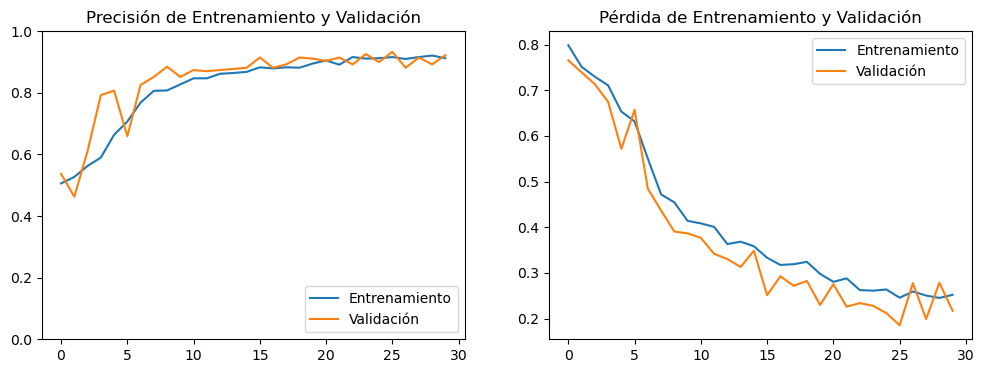

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9458 - loss: 0.1926
Precisión en el conjunto de prueba: 0.9504132270812988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


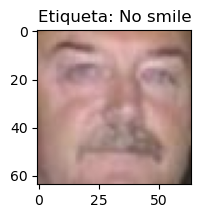

In [17]:
grafica_curvas_aprendizaje(his_basico_reg, 30)
evaluacion_prediccion(modelo_basico_reg)

### 6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

**Análisis y conclusiones de la primera estrategia**

1. Precisión (Accuracy):

La precisión del entrenamiento es muy buena y se llega a valores sobre el 99%, sin embargo no se observa lo mismo con la precisión de validación que si bien despues de 20ava epocas llega a valores moderados de 96% sin embargo la curva no es del todo suave. 

2. Pérdida (Loss):

La pérdida de entrenamiento decrece de manera significativa y rápida, lo cual es un buen indicador de aprendizaje.
La pérdida de validación sigue una tendencia similar a la de entrenamiento pero erratica al inicio, sin embargo se llega a valores de pérdida bajos. Esto lo conseguimos aumentando el numero de épocas.

3. Generalización:

Dado que aun no se consigue tener cercanía entre las líneas de precisión y pérdida de entrenamiento y validación se determina que el modelo no generaliza del todo bien y aun presenta un ligero sobreajuste.
Pensamos que no se pudo mejorar el sobreajuste debido al pequeño dataset de muestras (1203)

4. Consistencia:

No existe consistencia dado que as líneas de precisión no son bastante suaves, lo que sugiere utilizar técnicas de preentrenado y finetunning.


---


# **ESTRATEGIA 2 - TRANSFER LEARNING**


---

## Usando la RED Preentrenada VGG16

### 4. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [30]:
# Definición de datos mediante ImageDataGenerator usando la fucnión generacion_de_datos()

ancho_img = alto_img = 64
train_generator, val_generator, test_generator = generacion_de_datos(True,ancho_img,batch_size=16)

# Instanciamos nustro modelo base con la red preentrenada VGG16
base_model_VGG16 = VGG16(weights='imagenet',
                       include_top =False,
                       input_shape = (ancho_img,alto_img,3))
base_model_VGG16.summary()

# Descongelamos la última capa
for layer in base_model_VGG16.layers[:-2]:
    layer.trainable = False

# Construcción del modelo
preTrainedVGG16_model = Sequential(name="modelo_preentrenado_VGG16")
preTrainedVGG16_model.add(base_model_VGG16)
preTrainedVGG16_model.add(layers.GlobalAveragePooling2D())
preTrainedVGG16_model.add(layers.BatchNormalization())
preTrainedVGG16_model.add(layers.Dropout(0.1))
preTrainedVGG16_model.add(layers.Dense(512, activation="relu",kernel_regularizer=l2(0.001)))
preTrainedVGG16_model.add(layers.Dense(1, activation="sigmoid"))
preTrainedVGG16_model.summary()

# Definición de optimizador y compilado del modelo
optimizer = Adam(learning_rate=0.002)
preTrainedVGG16_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Entrenamos el model0
his_preTrainedVGG16 = preTrainedVGG16_model.fit(train_generator,
                        epochs = 20,
                        validation_data = val_generator)



Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "modelo_preentrenado_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 2,624,001 (10.01 MB)

 Non-trainable params: 12,355,904 (47.13 MB)

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.7543 - loss: 1.1579 - val_accuracy: 0.7370 - val_loss: 1.5274
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - accuracy: 0.8852 - loss: 0.6261 - val_accuracy: 0.8704 - val_loss: 0.7818
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step - accuracy: 0.9041 - loss: 0.5205 - val_accuracy: 0.8630 - val_loss: 0.6070
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.9093 - loss: 0.4097 - val_accuracy: 0.9037 - val_loss: 0.4513
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step - accuracy: 0.9041 - loss: 0.3848 - val_accuracy: 0.8926 - val_loss: 0.4000
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step - accuracy: 0.9330 - loss: 0.3140 - val_accuracy: 0.8963 - val_loss: 0.3485
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.9251 - loss: 0.2994 - val_accuracy: 0.9185 - val_loss: 0.3482
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step - accuracy: 0.9476 - loss: 0.2340 - val_accuracy: 0.907

### 5. Monitorización del proceso de entrenamiento para la toma de decisiones

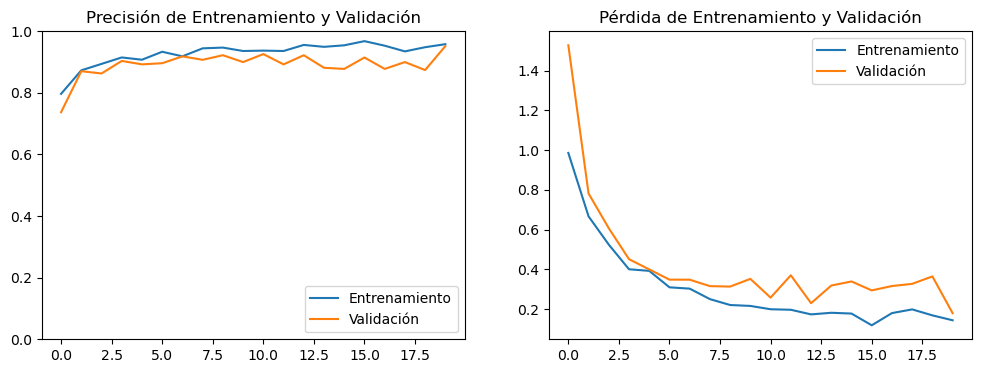

In [31]:
grafica_curvas_aprendizaje(his_preTrainedVGG16,20)

### 6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9257 - loss: 0.2245
Precisión en el conjunto de prueba: 0.9008264541625977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


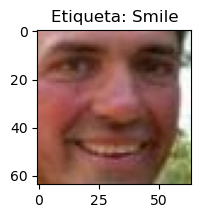

In [32]:
# Usamos las muestras del conjunto de test para predecir resultado
evaluacion_prediccion(preTrainedVGG16_model)

## Usando la RED Preentrenada MobilNet

### 4. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [21]:
# Definicio de datos mediante ImageDataGenerator en la fucnión feneracion_de_datos
train_generator, val_generator, test_generator = generacion_de_datos(True,64,batch_size=16)

# Instanciamos nustro modelo base con la red preentrenada MobileNet
base_model_MobileNetV2 = MobileNetV2(weights='imagenet',
                       include_top =False,
                       input_shape = (64,64,3))
base_model_MobileNetV2.summary()

for layer in base_model_MobileNetV2.layers[:-1]:
    layer.trainable = False

#last = base_model_ResNet.layers[-1].output

preTrainedResNet_model = Sequential(name="modelo_preentrenado_mobileNet")
preTrainedResNet_model.add(base_model_MobileNetV2)
preTrainedResNet_model.add(layers.GlobalAveragePooling2D())
preTrainedResNet_model.add(layers.BatchNormalization())
preTrainedResNet_model.add(layers.Dropout(0.3))
preTrainedResNet_model.add(layers.Dense(128, activation="relu",kernel_regularizer=l2(0.01)))
preTrainedResNet_model.add(layers.Dense(1, activation="sigmoid"))
preTrainedResNet_model.summary()

optimizer = Adam(learning_rate=0.002)
preTrainedResNet_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

steps_per_epoch_train = train_generator.n // train_generator.batch_size
steps_per_epoch_val = val_generator.n // val_generator.batch_size

# Entrenamos el model
his_preTrainedResNet = preTrainedResNet_model.fit(train_generator,
                        epochs = 15,
                        validation_data = val_generator)

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/tmp/ipykernel_128/1835126236.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_MobileNetV2 = MobileNetV2(weights='imagenet',


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "modelo_preentrenado_mobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,201 (9.26 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

Epoch 1/15


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.6521 - loss: 2.6267 - val_accuracy: 0.7889 - val_loss: 1.7739
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7393 - loss: 1.7846 - val_accuracy: 0.8222 - val_loss: 1.3053
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8388 - loss: 1.2288 - val_accuracy: 0.7778 - val_loss: 1.0858
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.7802 - loss: 1.0930 - val_accuracy: 0.7889 - val_loss: 0.9515
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7858 - loss: 0.8924 - val_accuracy: 0.8296 - val_loss: 0.7846
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8193 - loss: 0.7566 - val_accuracy: 0.7889 - val_loss: 0.7427
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8063 - loss: 0.7066 - val_accuracy: 0.8000 - val_loss: 0.6831
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7911 - loss: 0.6861 - val_accuracy: 0.7889 - val_loss: 

### 5. Monitorización del proceso de entrenamiento para la toma de decisiones

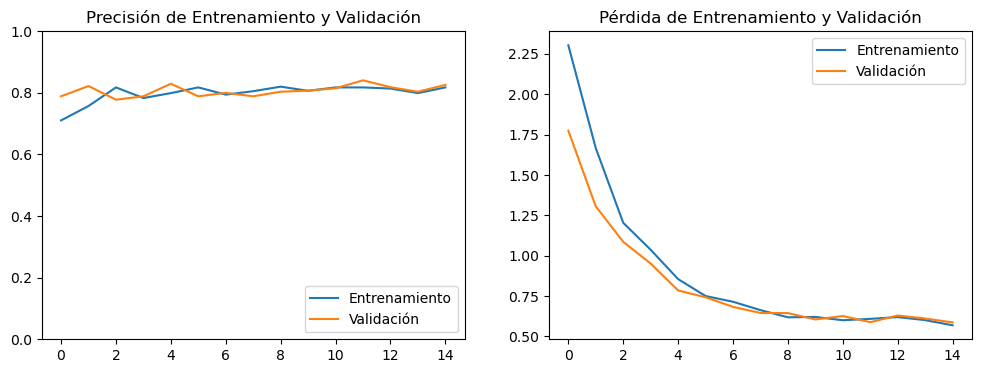

In [22]:
grafica_curvas_aprendizaje(his_preTrainedResNet,15)

### 6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8133 - loss: 0.5579
Precisión en el conjunto de prueba: 0.8099173307418823
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


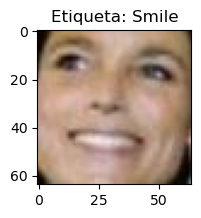

In [26]:
# Usamos las muestras del conjunto de test para predecir resultado
evaluacion_prediccion(preTrainedResNet_model)